<a href="https://colab.research.google.com/github/mrunalmania/Pytorch-Learning/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 Pytorch Transfer Learning

What is transfer learning?
Transfer learning involves taking the parameters of what one model has learned
on another dataset and applying to our own problem

* Pretrained model = Foundation models

Please read: Multi-weight Support API

In [ ]:
import torch
import torchvision

In [ ]:
print(torch.__version__) # want 1.12 and higher
print(torchvision.__version__) # want 0.13 and higher

2.0.0+cu118
0.15.1+cu118


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[Info]: torchinfo is not present, installing it...")
  !pip install -q torchinfo
  from torchinfo import summary
# we need to clone the repos from 05 module.
try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[Info]: we need to clone the repos.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import engine, data_setup

[Info]: torchinfo is not present, installing it...
[Info]: we need to clone the repos.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3710, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 3710 (delta 176), reused 299 (delta 153), pack-reused 3378
Receiving objects: 100% (3710/3710), 648.79 MiB | 24.72 MiB/s, done.
Resolving deltas: 100% (2132/2132), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

## 1. Get some data

We need our pizza, steak, sushi data to build a transfer learning model

In [ ]:
import os
import zipfile

from pathlib import Path
import requests
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from subset of classes from the Food101

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exist, skipping download part..")
else:
  print(f"Did not find {image_path}, download it.")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data..")
    f.write(request.content)

  # unzip data.
  with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping...")
    zip_ref.extractall(image_path)
  
  # Remove zip file
  os.remove(data_path/ "pizza_steak_sushi.zip")




Did not find data/pizza_steak_sushi, download it.
unzipping...


In [ ]:
# setup direcotory path
train_dir = image_path/ "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data, want to turn it into PyTorch dataloaders.
To do so, we can use `data_setup.py` function we made in 05. PyTorch going modular.

There's one thing we have to think about when loadind: how to **transform** it?

And with `torchvision` 0.13+ there's 2 ways to do this.
1. Manually created transforms - you decide what transforms you want your data to go through.
2. Automatically created transforms. - the tranforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is the same way that the data model was trained on.


In [ ]:
from going_modular.going_modular import data_setup


### 2.1 creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within  `torchvision`

> All pretrained model expect input images normalized in the same way. i.e mini batchee of 3-channel RGB images of shape (3 X H X W), where H and W are expected to be 224. And the images have to be loaded in to the range of [0,1] and then normalized using mean=[0.485,0.456,0.406] and std = [0.229,0.224,0.225]. You can use the following transform to normalize.



In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(
    mean = [0.485,0.456,0.406],
    std = [0.229,0.224,0.225]
)

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resize images to 224, 224
    transforms.ToTensor(), # get images into range [0,1]
    normalize
])

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f916cc0d450>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvison.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you are using.

In [ ]:
import torchvision
torchvision.__version__

'0.15.1+cu118'

In [ ]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = Best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transform used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = 32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f916cc0e770>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get pretrained model
1. Pytorch doamin libraries
2. Libraries like `timm` (torch image models)
3. Hugging face Hub (for plenty of different models)
4. Papers with codes( for models across different problem spaces/domains)

#### 3.1 Which pretrained model you should use?
* Experiment, Experiment, Experiment! *

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize 
to your own problem

Three things to consider
1. Speed - how fast does it  need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g how well does it classify food images? for food vison mini)?

Where does the model live?

Is it on device (like self driving car_

or does it live on server ?

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

which mdoel should we use? 
We need to go for highest accuracy and lowest params (because more params means model takes more time)

For our case (deploying our model FoodVisionMini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of The bitter lesson, if we had infinte compute, we'd likely pick the biggest model +  most parameter + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html


### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0.

In [ ]:
# Method of creatig pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device=device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo`

In [ ]:
# print summary from torchinfo
from torchinfo import summary
summary(
    model = model,
    input_size=(1,3,224,224), # example of [batch_Size, color chanel, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names']
)

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base mode and changing the output layer to suit our needs

With a feature extractor model, typically you will *freeze* the base layers of a pretrained/foundation model and update the output layer to suit your own problem.

In [ ]:
# Freeze all of the base layer in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False # To freeze the layer, we need to False their gradient tracking.


In [ ]:
# Update the classifier head of our model to suit our problem
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280, # feature vector comming in
              out_features=len(class_names)) # how many classes do we have [pizza, steak, sushi]
).to(device)

In [ ]:
summary(
    model = model,
    input_size=(1,3,224,224), # example of [batch_Size, color chanel, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names']
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model


In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [ ]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the timer
from timeit import default_timer as timer
start_time = timer()

# setip training and save the results
results = engine.train(
    model=model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 5,
    device = device
)

# end the timer
end_time = timer()
print(f"[INFO] Total training time {end_time-start_time} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9211 | train_acc: 0.6562 | test_loss: 0.7920 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7553 | train_acc: 0.8672 | test_loss: 0.6486 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7376 | train_acc: 0.7070 | test_loss: 0.5954 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6272 | train_acc: 0.7656 | test_loss: 0.6106 | test_acc: 0.8968
[INFO] Total training time 193.13524981499998 seconds


In [ ]:
results

{'train_loss': [1.0977481752634048,
  0.9210745468735695,
  0.755328893661499,
  0.7376011088490486,
  0.627163402736187],
 'train_acc': [0.3828125, 0.65625, 0.8671875, 0.70703125, 0.765625],
 'test_loss': [0.8855527639389038,
  0.7919705112775167,
  0.648608128229777,
  0.5954257448514303,
  0.6105525096257528],
 'test_acc': [0.6827651515151515,
  0.8257575757575758,
  0.9166666666666666,
  0.8958333333333334,
  0.8967803030303031]}

## 5. Evaluate our model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


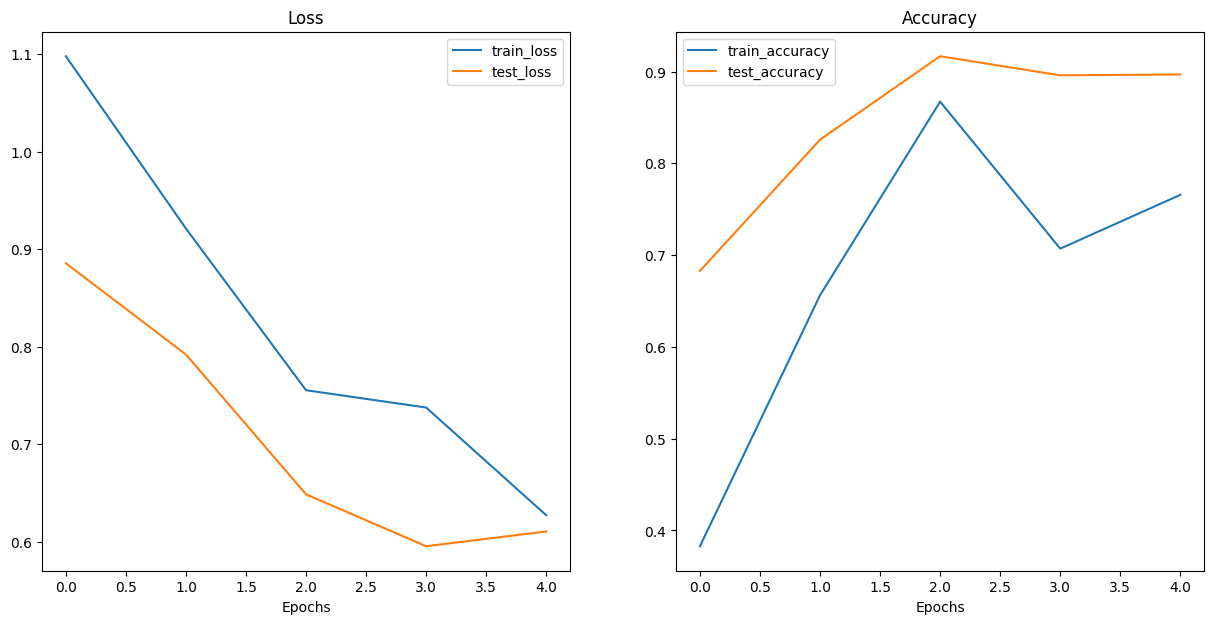

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves


# plot the loss curves of our model
plot_loss_curves(results)

what do our loss curves look like in terms of ideal loss curves?
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make some predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize,  visualize, visualize!*

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same datatype.
* Same device - custom data should be on the same device as the model
* Same transorm - if you have transformed your custom data, ideally you will transform your test data and custom data.

To do all of this automatically, let's create a function called `pred_and_plot_image()`:
The function will be similar to the one here:
 https://www.learnpytorch.io/04_pytorch_custom_datasets/#11-make-a-prediction-on-a-custom-image
 

 1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a traget device

 2. Open the image with `PIL.Image.Open()`
 3. Create a transform if one doesn't exist
 4. Make sure, the model on the target device
 5. Turn the model to `model.eval()` mode to make sure it's ready for inference.
 (this will turn off things like `nn.Dropout()`)
 6. Transform the target iage and make sure its dimensionality is suited for the model (this mainly related to the batch size)
 7. Make a prediction on the image by passing it to the model
 8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
 9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
 10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from torchvision.transforms.transforms import ToTensor
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take in a traditional model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2 open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform is one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = torchvision.transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
  ### predict on image
  # 4. Make sure model is on target device 
  model.to(device)

  # 5. Turn on inference model and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch size, color channel, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on target device)
    target_image_pred = model(transformed_image).to(device)
  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot the image wih predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)



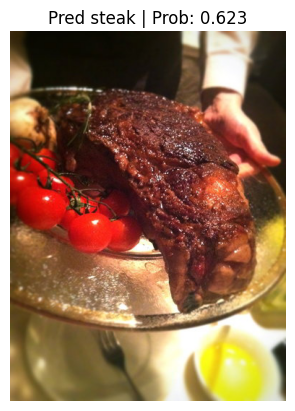

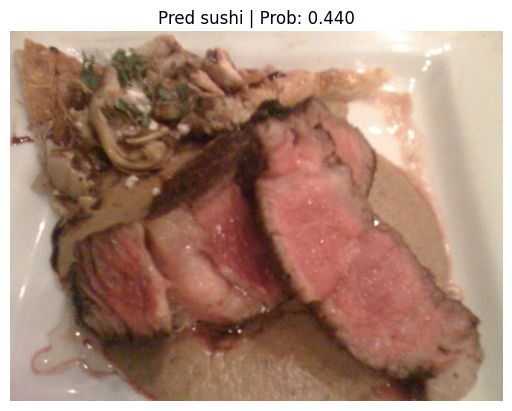

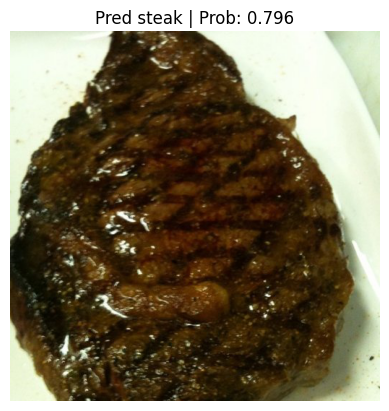

In [ ]:
# making prediction on test dataset
# Get a random list of image paths from the test set
import random
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_smaple = random.sample(population=test_image_path_list,
                                       k = num_image_to_plot)
test_image_path_smaple

# Make prediction on and plot the images
for image_path in test_image_path_smaple:
  pred_and_plot_image(model=model,
                      image_path = image_path,
                      class_names =class_names,
                      image_size=(224,224))

### 6.1 Making prediction on custom image
Let's make a predicton on custom image


In [ ]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path/ "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Downloaf image from the GitHub with raw link
    req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f'Downloading {custom_image_path}....')
    f.write(req.content)
else:
  print(f"{custom_image_path} already exist, skipping download")


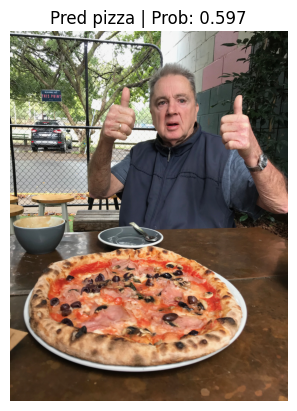

In [ ]:
pred_and_plot_image(
    model = model,
    image_path = custom_image_path,
    class_names = class_names
)